In [1]:
import numpy as np
import pyuvdata
import os
import matplotlib.pyplot as plt


In [67]:
data = pyuvdata.UVData()
data.read(
    "/safepool/rbyrne/hera_data/H6C-data/2459861/zen.2459861.45004.sum.abs_calibrated.red_avg.uvh5"
)
model = pyuvdata.UVData()
#model.read(
#   "/safepool/rbyrne/hera_data/simulated_model_vis/zen.2459861.45004.fftvis_sim.uvfits"
#)
# model.read(
#    "/safepool/rbyrne/hera_data/H4C-Abscal-Model/zen.2458894.09630.uvh5"
# )
model.read(
    "/safepool/rbyrne/hera_data/interpolated_models/zen.2459861.45004.sum.abs_calibrated.red_avg_model.uvfits"
)

In [68]:
use_time = np.max(data.time_array)
data.select(times=use_time)
model_times = list(set(model.time_array))
model.select(
    times=model_times[
        np.where(model_times - use_time == np.min(model_times - use_time))[0][0]
    ]
)

In [69]:
data.data_array[np.where(data.flag_array)] = np.nan

In [70]:
data.phase_to_time(np.mean(data.time_array))
model.phase_to_time(np.mean(data.time_array))

In [71]:
data.inflate_by_redundancy(use_grid_alg=True)
model.inflate_by_redundancy(use_grid_alg=True)

Missing some redundant groups. Filling in available data.
Missing some redundant groups. Filling in available data.


In [72]:
data.conjugate_bls()
model.conjugate_bls()

In [73]:
data_baselines = list(set(zip(data.ant_1_array, data.ant_2_array)))
model_baselines = list(set(zip(model.ant_1_array, model.ant_2_array)))
use_baselines = [baseline for baseline in data_baselines if baseline in model_baselines]
use_pols = np.intersect1d(data.polarization_array, model.polarization_array)

In [74]:
data.select(bls=use_baselines, polarizations=use_pols)
model.select(bls=use_baselines, polarizations=use_pols)

In [75]:
data.reorder_blts()
model.reorder_blts()
data.reorder_pols(order="AIPS")
model.reorder_pols(order="AIPS")
data.reorder_freqs(channel_order="freq")
model.reorder_freqs(channel_order="freq")

In [76]:
# Confirm data ordering matches:
print(np.max(np.abs(data.ant_1_array - model.ant_1_array)))
print(np.max(np.abs(data.ant_2_array - model.ant_2_array)))
print(np.max(np.abs(data.freq_array - model.freq_array)))
print(np.max(np.abs(data.time_array - model.time_array)))
print(np.max(np.abs(data.polarization_array - model.polarization_array)))

0
0
0.0
0.00011184811592102051
0


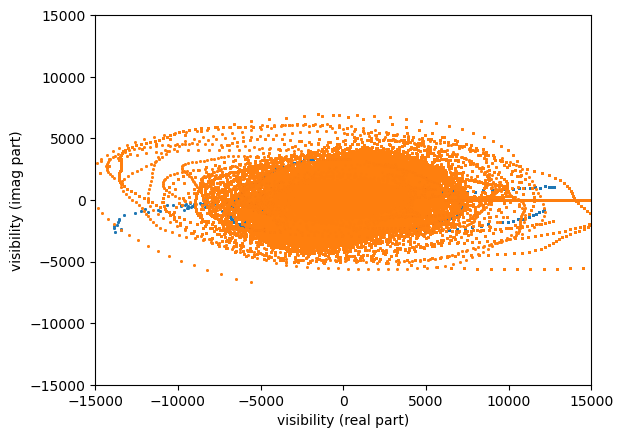

In [77]:
plt.scatter(np.real(data.data_array), np.imag(data.data_array), 1, marker=".")
plt.scatter(np.real(model.data_array), np.imag(model.data_array), 1, marker=".")
plt.xlabel("visibility (real part)")
plt.ylabel("visibility (imag part)")
plt.xlim([-15000, 15000])
plt.ylim([-15000, 15000])
plt.show()

In [78]:
print(np.nanmean(np.abs(data.data_array)))
print(np.nanmean(np.abs(data.data_array - model.data_array)))

625.3760174933876
228.80463404428318


Mean of empty slice


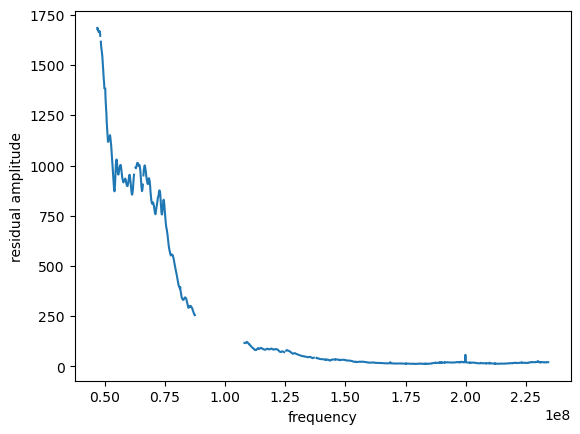

In [79]:
plt.plot(
    data.freq_array, np.nanmean(np.abs(data.data_array - model.data_array), axis=(0, 2))
)
plt.xlabel("frequency")
plt.ylabel("residual amplitude")
plt.show()

Mean of empty slice


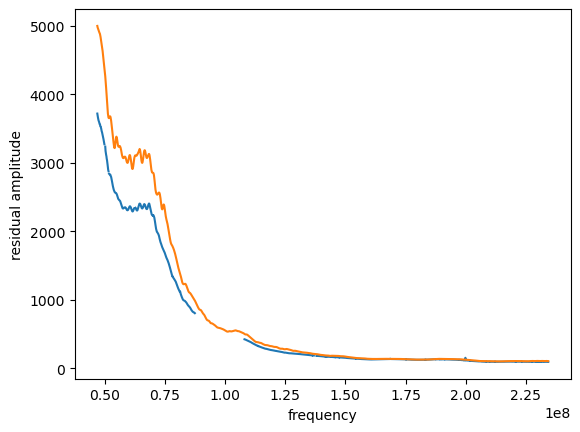

In [80]:
plt.plot(
    data.freq_array, np.nanmean(np.abs(data.data_array), axis=(0, 2))
)
plt.plot(model.freq_array, np.nanmean(np.abs(model.data_array), axis=(0, 2)))
plt.xlabel("frequency")
plt.ylabel("residual amplitude")
plt.show()

Mean of empty slice
Mean of empty slice


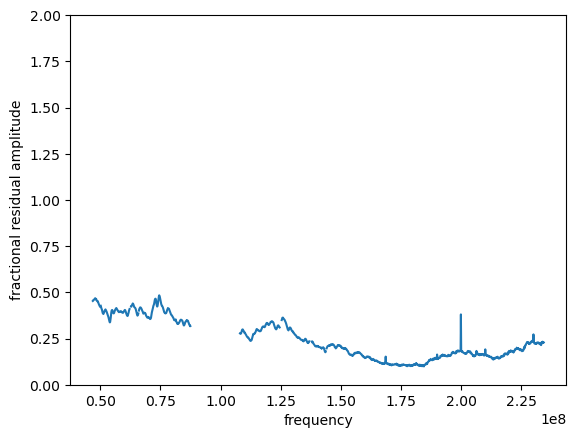

In [81]:
plt.plot(
    data.freq_array,
    np.nanmean(np.abs(data.data_array - model.data_array), axis=(0, 2))
    / np.nanmean(np.abs(data.data_array), axis=(0, 2)),
)
plt.xlabel("frequency")
plt.ylabel("fractional residual amplitude")
plt.ylim([0,2])
plt.show()

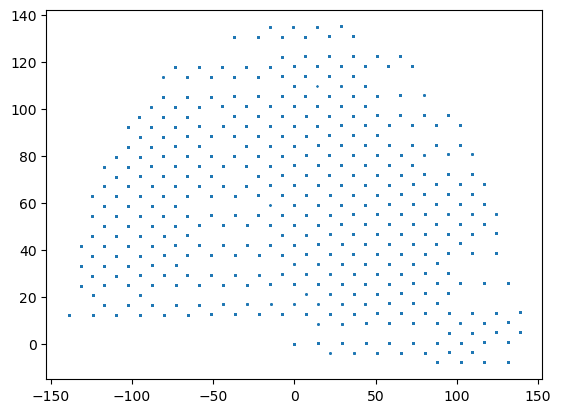

In [16]:
plt.scatter(data.uvw_array[:, 0], data.uvw_array[:, 1], 1, marker=".")
plt.show()

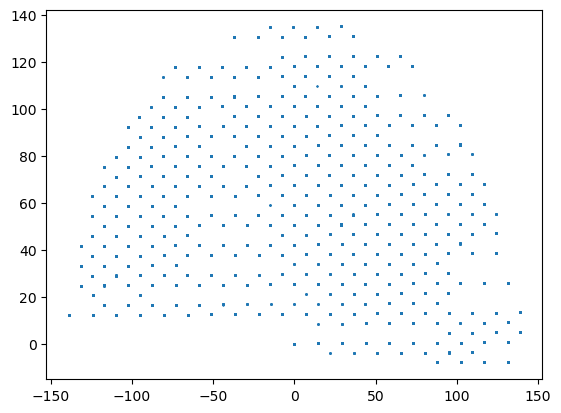

In [17]:
data_copy = data.copy()
data_copy.set_uvws_from_antenna_positions()
plt.scatter(data_copy.uvw_array[:, 0], data_copy.uvw_array[:, 1], 1, marker=".")
plt.show()

In [18]:
antpos, ants = model.get_ENU_antpos()
print(np.shape(antpos))

(350, 3)


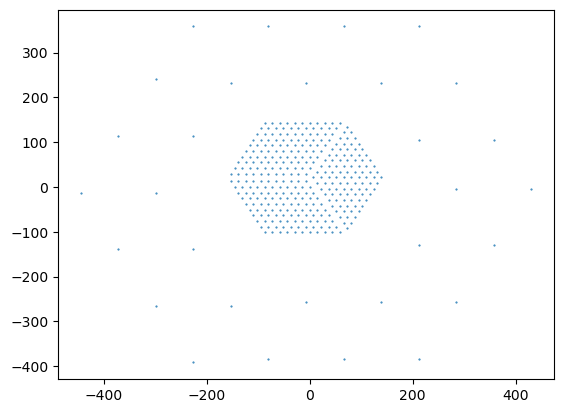

In [19]:
plt.scatter(antpos[:, 0], antpos[:, 1], 1, marker=".")
plt.show()

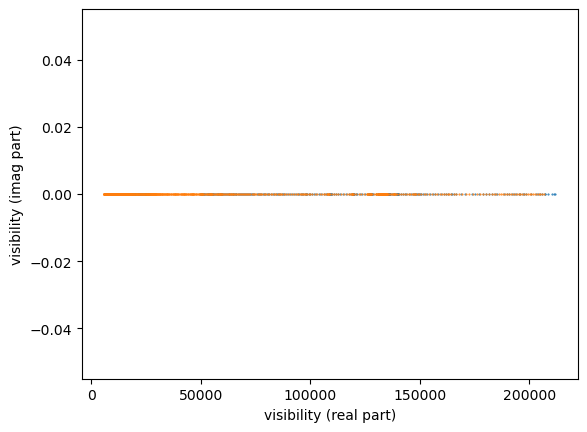

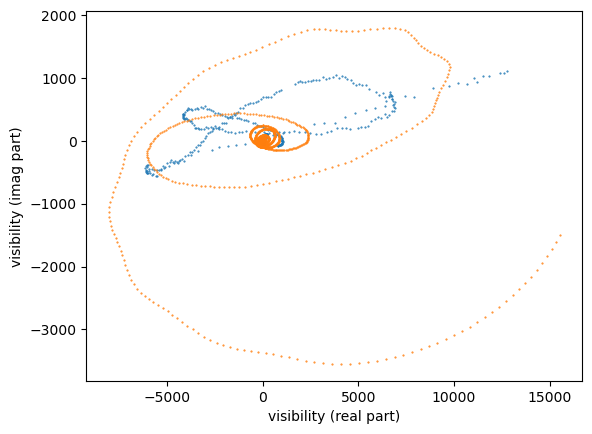

In [20]:
for use_baseline in range(2):
    plt.scatter(
        np.real(data.data_array[use_baseline, :, 0]),
        np.imag(data.data_array[use_baseline, :, 0]),
        1,
        marker=".",
    )
    plt.scatter(
        np.real(model.data_array[use_baseline, :, 0]),
        np.imag(model.data_array[use_baseline, :, 0]),
        1,
        marker=".",
    )
    plt.xlabel("visibility (real part)")
    plt.ylabel("visibility (imag part)")
    #plt.xlim([-10000, 10000])
    #plt.ylim([-10000, 10000])
    plt.show()

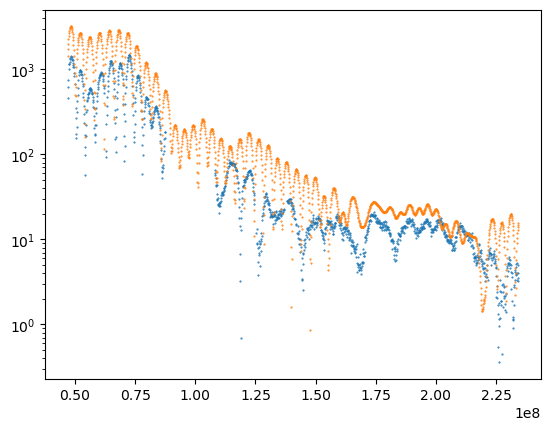

In [21]:
use_baseline = 200
plt.scatter(
    data.freq_array,
    np.abs(data.data_array[use_baseline, :, 0]),
    1,
    marker=".",
)
plt.scatter(
    model.freq_array,
    np.abs(model.data_array[use_baseline, :, 0]),
    1,
    marker=".",
)
plt.yscale('log')
plt.show()

In [22]:
print(data.uvw_array[use_baseline, :])
print(model.uvw_array[use_baseline, :])

[-36.57808317  12.47752035  -0.09991563]
[-36.51029051  12.61024533  -0.04000083]


In [23]:
print(list(set(data.ant_1_array)))
print(list(set(data.ant_2_array)))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

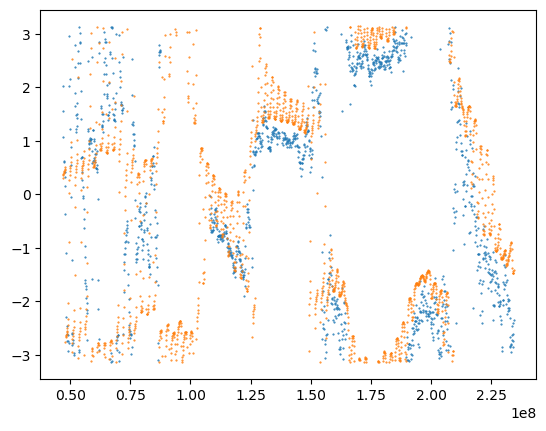

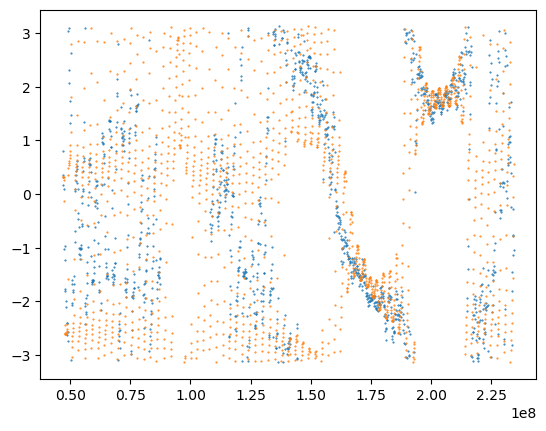

In [24]:
baselines = list(set(zip(data.ant_1_array, data.ant_2_array)))
for bl in baselines[0:2]:
    data_copy = data.copy()
    data_copy.select(bls=bl)
    model_copy = model.copy()
    model_copy.select(bls=bl)
    plt.scatter(
        data_copy.freq_array,
        np.angle(data_copy.data_array[0, :, 0]),
        1,
        marker=".",
    )
    plt.scatter(
        model_copy.freq_array,
        np.angle(model_copy.data_array[0, :, 0]),
        1,
        marker=".",
    )
    #plt.yscale("log")
    plt.show()

In [56]:
data.compress_by_redundancy(use_grid_alg=True)
model.compress_by_redundancy(use_grid_alg=True)

Mean of empty slice
Mean of empty slice


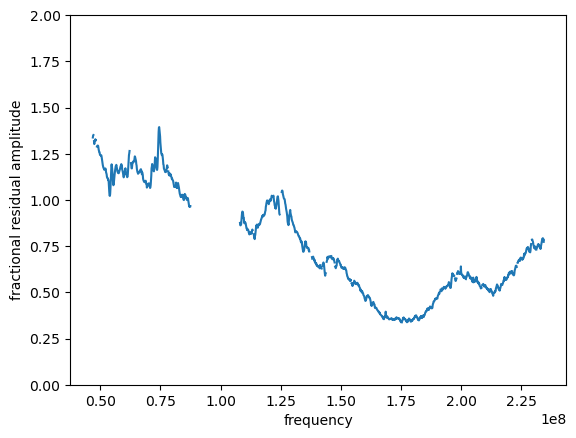

In [57]:
plt.plot(
    data.freq_array,
    np.nanmean(np.abs(data.data_array - model.data_array), axis=(0, 2))
    / np.nanmean(np.abs(data.data_array), axis=(0, 2)),
)
plt.xlabel("frequency")
plt.ylabel("fractional residual amplitude")
plt.ylim([0, 2])
plt.show()

In [ ]:
model.get_data((160, 110))

KeyError: 'Antenna pair (160, 110) not found in data'

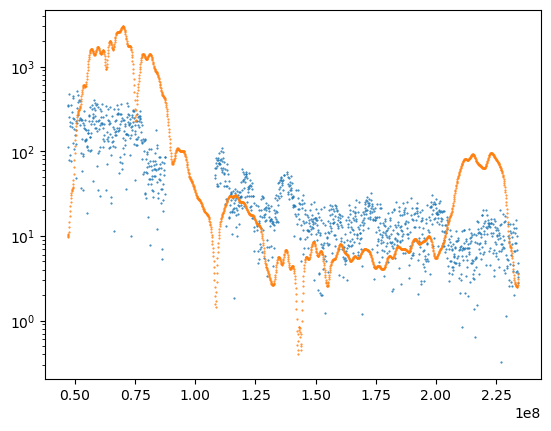

In [ ]:
plt.scatter(
    data_copy.freq_array,
    np.abs(data_copy.data_array[0, :, 0]),
    1,
    marker=".",
)
plt.scatter(
    model_copy.freq_array,
    np.abs(model_copy.data_array[0, :, 0]),
    1,
    marker=".",
)
plt.yscale("log")
plt.show()

In [ ]:
def get_antenna_pair_from_baseline_nums(baseline_nums):
    ant2 = (baseline_nums - 2**16) % 2048
    ant1 = [int(value) for value in (baseline_nums - 2**16 - ant2) / 2048]
    return list(zip(ant1, ant2))

In [ ]:
data.conjugate_bls()
data.inflate_by_redundancy(use_grid_alg=True)
red_baselines, _, _, conj_red_baselines = data.get_redundancies(
    include_conjugates=True
)
data.compress_by_redundancy()

red_groups_data = np.full((data.Nbls), np.nan, int)
for bl_ind, baseline in enumerate(
    list(zip(data.ant_1_array, data.ant_2_array))
):
    for red_ind, red_group in enumerate(red_baselines):
        red_group_ants = get_antenna_pair_from_baseline_nums(
            np.array(red_group)
        )
        if baseline in red_group_ants:
            red_groups_data[bl_ind] = red_ind
        elif baseline[::-1] in red_group_ants:
            ant1 = data.ant_2_array[bl_ind]
            ant2 = data.ant_1_array[bl_ind]
            data.baseline_array[bl_ind] = 2048 * ant1 + ant2 + 2**16
            data.data_array[bl_ind, :, :] = np.conj(
                data.data_array[bl_ind, :, :]
            )
            data.ant_1_array[bl_ind] = ant2
            data.ant_2_array[bl_ind] = ant1
            red_groups_data[bl_ind] = red_ind

red_groups_model = np.full((model.Nbls), np.nan, int)
for bl_ind, baseline in enumerate(
    list(zip(model.ant_1_array, model.ant_2_array))
):
    for red_ind, red_group in enumerate(red_baselines):
        red_group_ants = get_antenna_pair_from_baseline_nums(
            np.array(red_group)
        )
        if baseline in red_group_ants:
            red_groups_model[bl_ind] = red_ind
            continue
        elif baseline[::-1] in red_group_ants:
            ant1 = model.ant_2_array[bl_ind]
            ant2 = model.ant_1_array[bl_ind]
            model.baseline_array[bl_ind] = 2048 * ant1 + ant2 + 2**16
            model.data_array[bl_ind, :, :] = np.conj(
                model.data_array[bl_ind, :, :]
            )
            model.ant_1_array[bl_ind] = ant2
            model.ant_2_array[bl_ind] = ant1
            red_groups_model[bl_ind] = red_ind
            continue

use_red_groups = [
    group for group in red_groups_data if group in red_groups_model
]
use_data = np.zeros(
    (len(use_red_groups), data.Nfreqs, data.Npols), dtype=complex
)
use_model = np.zeros(
    (len(use_red_groups), data.Nfreqs, data.Npols), dtype=complex
)
for group_ind, group in enumerate(use_red_groups):
    use_data[group_ind, :, :] = data.data_array[
        np.where(red_groups_data == group)[0], :, :
    ]
    use_data[
        np.where(data.flag_array[np.where(red_groups_data == group)[0], :, :])
    ] = (np.nan + 1j * np.nan)
    use_model[group_ind, :, :] = model.data_array[
        np.where(red_groups_model == group)[0], :, :
    ]
    use_model[
        np.where(data.flag_array[np.where(red_groups_data == group)[0], :, :])
    ] = (np.nan + 1j * np.nan)

plt.scatter(np.real(use_data), np.imag(use_data), marker=".")
plt.scatter(np.real(use_model), np.imag(use_model), marker=".")
plt.xlabel("visibility (real part)")
plt.ylabel("visibility (imag part)")
plt.show()

Missing some redundant groups. Filling in available data.
The use_grid_alg parameter is not set. Defaulting to True to use the new gridding based algorithm (developed by the HERA team) rather than the older clustering based algorithm. This is change to the default, to use the clustering algorithm set use_grid_alg=False.
invalid value encountered in cast


IndexError: index 826 is out of bounds for axis 0 with size 826

In [62]:
print(np.sort(list(set(data.time_array))))
print(np.sort(list(set(model.time_array))))

[2459861.44998783]
[2459861.44998783]


In [64]:
len(data.freq_array)

1536

In [65]:
len(model.freq_array)

1536